# How to Reduce Telco Customer Churn
By Joshua Mayes  
2022-07-13

## About this notebook



### Goals
A telecom company is experiencing a high rate of customers discontinuing their service, an event that they refer to as "churn" or "turnover rate".  The company wants to know why their customers are churning so that they can patch any flaws in their service offerings.  They also want to be able to identify which customers are likely to churn in the future so that the customer retention team can pre-emptively contact them and attempt to retain them.

### Outline

First, this notebook will attempt to answer the question "Why are customers churning?".  It will present a collection of features that were identified as drivers of customer churn and evidence of their influence in the form of data visualizations and statistical testing.

Second, it will attempt to answer the question "What can the company do to reduce customer churn?" by recommending changes to the business model that should positively impact the rate of customer churn.

Third, this notebook will demonstrate a simple machine learning model that can be used to monitor customer data, enabling the company to more effectively intervene on customers with a high churn risk.

Finally, this notebook will include an appendix that describes more in depth the process and decisions that went into answering these questions.



### How to reproduce this notebook


This notebook makes use of several python libraries that are not included in the base installation of python.  You can use pip to install them easily by running the following commands in your python shell.
```
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install plotly
%pip install scipy
%pip install sklearn
```

In [2]:
# Common Data Science Libraries
import pandas as pd
import numpy as np
# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Sklearn metrics
from sklearn import metrics

Additionally some helper libraries have been included to hide complicated code and prevent cluttering of this notebook.

In [3]:
# Helper libraries with custom functions
import wrangle
import model

These libraries can be used to quickly and easily get the data into your python environment.

In [4]:
# Load a cleaned and prepared version of the Telco Churn dataset
data = wrangle.get_tidier_telco_data()
# Split the dataset into smaller datasets to prevent data-leakage when exploring the data and training the model
train, test, validate, verify = wrangle.train_test_validate_verify_split(data)
# Separate the target variable from the feature list for use with Machine Learning models
X_train, y_train = wrangle.x_y_split(train)
X_test, y_test = wrangle.x_y_split(test)

For a more in-depth look at the exploration and research, a detailed walkthrough can be found in [prep-explore.ipynb](./prep-explore.ipynb).  


## What are the most impactful drivers of churn?

By plotting each column's correllation to the churn column, and cutting away all of columns with the weakest correlation we can get a very good picture of the answer.

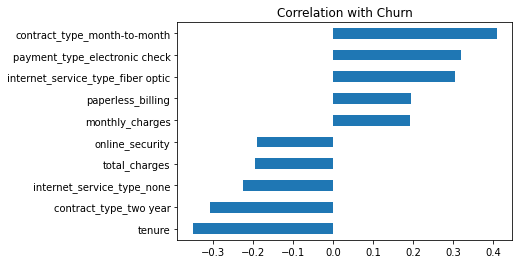

In [5]:
# Get a correllation matrix of the train dataset, then narrow it down to only the churn column
x = train.corr().churn
# We don't care how churn correlates with itself, so drop that row. Then sort the values.
x = x.drop(labels='churn').sort_values()
# Cut away all of the columns with a weak correlation, and plot them in a horizontal bar graph.
# "Weak" is arbitrarily defined as between -0.18 and 0.18
ax = x[abs(x) > .18].plot(kind='barh')
# Give our graph a meaningful title
ax.set_title('Correlation with Churn')
plt.show()

There is a lot of good information in this one chart, but it can be a little difficult to interpret.  The bars that extend to the right represent a positive correlation, while the ones to the left represent a negative correlation.

As a rule of thumb, if a variable has a strong correlation with our target variable (regardless of whether the correlation is positive or negative), then it has a strong predictive power for our target variable.

Unfortunately in this case none of these variables have a particularly strong correlation with our target variable.  A 100% correlation would represent a perfect predictor, but the highest we see here is just below 40%.  However, these variables can still work in concert with one another to help tell the story of why customers are churning and to identify a customer's risk of churn.

## Why is contract type a strong predictor?

Let's take a closer look at the strongest correlators.  We'll start with contract type since it appears twice in our list of strongest correlators, once for the strongest positive correlator (month-to-month contracts) and again as the second strongest negative correlator (two-year contracts).



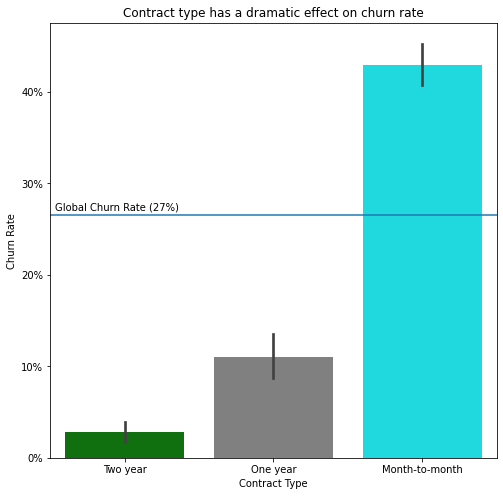

In [6]:
# Manually define the figure size for readability
plt.figure(figsize = (8,8))
# Get the perfect shade of blue
sblue = '#00F7FF' 
# Define the churn-rate for all customers for comparison
gcr = train.churn.mean()
# Draw the plot
sns.barplot(
            data = train, 
            y='churn', 
            x='contract_type', 
            order=['Two year','One year','Month-to-month'],
            palette=['green','grey',sblue]
            ).set(
                title='Contract type has a dramatic effect on churn rate')
# Draw a line on the plot to represent the global churn rate
plt.axhline(gcr)
plt.text(-0.47, gcr+.005, 'Global Churn Rate ({:.0%})'.format(gcr))
# Beautify the figure with some labels and formatting.
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

By plotting the percentage of customers who churn with each contract type we can see that the churn-rate for month-to-month customers heavily outweigh the other two contract types.

We can also see the negative correlation of Two-year contracts in effect here. That bar is much shorter than the other two.

Overall, the dramatic shift in churn rates across the different contract types lends this variable to being a very strong predictor of customer churn.  However, it certainly is not the *only* predictor.  

Further down the list of strong correlators we find `internet_service_type_fiber_optic` and `internet_service_type_none`.  Lets examine.

## Is there something wrong with Fiber Optic internet?

By doing the same thing for Internet Service types, we can see a very similar story.

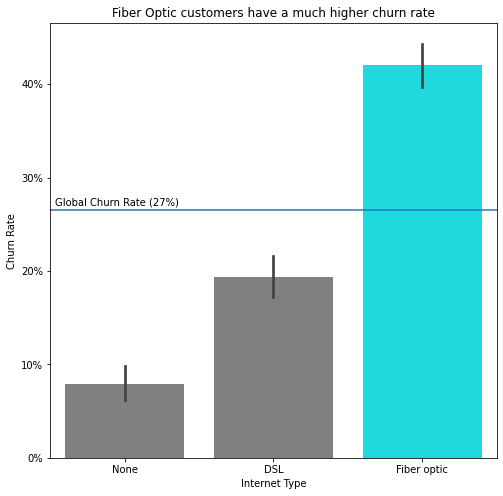

In [7]:
# Using the same method as the chart above, plot the churn rate across internet service types.
plt.figure(figsize = (8,8))
sblue = '#00F7FF'
gcr = train.churn.mean()
churn = sns.barplot(
                    data = train, 
                    y='churn', 
                    x='internet_service_type', 
                    order=['None','DSL','Fiber optic'],
                    palette=['grey','grey',sblue],
                    ).set(
                        title='Fiber Optic customers have a much higher churn rate')
plt.axhline(gcr)
plt.text(-0.47, gcr+.005, 'Global Churn Rate ({:.0%})'.format(gcr))
plt.ylabel('Churn Rate')
plt.xlabel('Internet Type')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)

These two graphs look very similar right?  Perhaps a bit **too** similar?


## Is that similarity a fluke?


There might be a story in that similarity, but before we start jumping to any conclusions we should ask the question: 
>"Is that similarity statistically significant?"

We can answer that question with a $chi^2$ test, which determines what a distribution of values would be if they were independant of one another and compares that with the actual distribution.


##### $ Chi^2 $ test between Contract Type and Internet Type


Statistical Analysis can be a bit weird, but bear with us as we set up the test.

$ \alpha$ (Confidence level) = 0.05, if there is more that a 5% chance that we got this distribution randomly, then we can't assume a relationship  
$ H_0 $ (Null Hypothesis): We are wrong and there is no relationship between contract type and internet type.  
$ H_A $ (Alternate Hypothesis): There is in fact a relationship between the two.  

In [8]:
# Set up a crosstab matrix that represents the distribution of values
inet_ctType = pd.crosstab(train.contract_type, train.internet_service_type)
# Perform the statistical test
model.chi2_test(inet_ctType, alpha=0.05)
# Display the crosstab to make the test results more clear
inet_ctType

Observed

[[ 630 1049  254]
 [ 278  258  188]
 [ 322  202  340]]
---
Expected

[[675 828 429]
 [252 310 160]
 [301 370 191]]
---

chi^2 = 341.3978
degf = 4
p     = 0.0000
---

We reject the null hypothesis


internet_service_type,DSL,Fiber optic,None
contract_type,,,
Month-to-month,630,1049,254
One year,278,258,188
Two year,322,202,340


The statistical test confirms our suspicion (Or more accurately: it makes us more confident that we can assume that our suspicion is true.)

Unfortunately, although the relationship between our two variables is interesting, it's not very actionable.  However, it highlights that there might have been a recent promotion that is contributing to customer churn and opens up a lot of possibility for speculation.

For example, did the company recently run a promotion that heavily incentivised new customers to sign up for fiber-optic internet with a month-to-month contract? Maybe there was a spike of new customers because the promotion advertised that the first month was free, and now that they've gotten their free month of internet they are jumping ship.

Unfortunately, we don't have any data on whether or not a customer was taking advantage of a promotion.  But we can definitely use our next feature to see if there was a recent spike in new customers.

## Was there a recent promotion?

We can see from this graph that there was in fact recent spike in new customers and that the majority of them have already churned from the company.  This supports our theory of a recent promotion.  

However, we can also see that the rate of churn has been steadily increasing over the years indicating that there's more going on here than a single promotion.  Perhaps this pattern also lends some credence to our earlier theorty that the quality of service on the company's internet service has degraded?

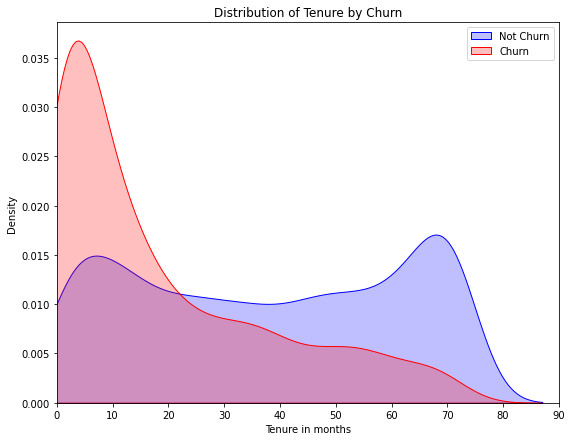

In [25]:
# Set the figure size manually for better readability
plt.figure(figsize = (9,7))
# Draw the distribution of tenure for customers who didn't churn
ax = sns.kdeplot(train.tenure[~train.churn],
                color="Blue", shade = True)
# On the same axes draw the distribution of tenure for customers who *did* churn
ax = sns.kdeplot(train.tenure[train.churn ],
                ax=ax, color="Red", shade= True)

# Prettify the graph with some labels and a legend
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Tenure in months')
ax.set_xlim(0,90)
ax.set_title('Distribution of Tenure by Churn')
plt.show()

### The new customers are jumping ship
By plotting the distribution of customers by their tenure, and splitting them by churn, we can see more clearly how tenure becomes a negative correlator with churn.

# Recommendations to reduce churn

### Recommendation 1: If there was a recent promotion, don't run that promotion again.

With the three features that we've analyzed, each of them have hinted that there might have been a recent promotion causing a relationship between all three.  A huge bulk of churning customers are customers with a relatively short tenure, indicating that if there were a promotion it actually incentivized a short tenure with the company.

### Recommendation 2: Deincentivize month-to-month contracts and incentivize two-year contracts.

We saw earlier that across the different contract types, month-to-month was far and away the worst offender for churn.  By introducing higher costs on month-to-month contracts the company both recovers lost revenue from churn, and subtly guides customers into selecting contracts with a longer term.  That subtle nudged can then be re-inforced by discounting two-year contracts, which was far and away the least offender for churn.

### Recommendation 3: Monitor customer data and intervene on high-risk customers.

The company is by no means forced to lay down and accept its fate when it comes to customer churn.  By implementing an algorithm that can predict customer churn, the company can focus customer retention efforts and preemptively contact the customers with the highest risk of churn.

Of course, there is going to be some concerns about the ROI (Return On Investement) of implementing a process, so here is a chart that shows how successful the process needs to be in order to see an ROI.

#### ROI on model monitoring

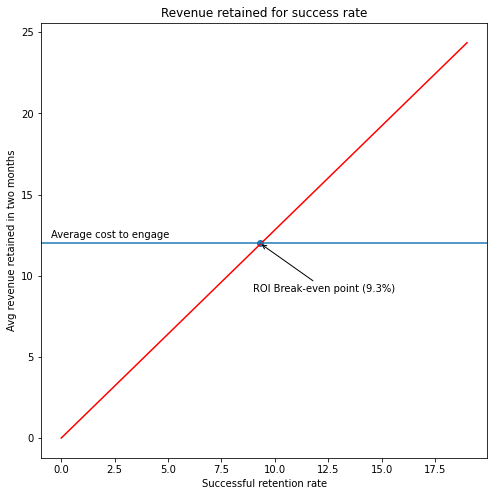

In [10]:
# Plot the revenue retained based on retention sucess rate

avg_cust_rev = train.monthly_charges.mean()
x = range(0,20)
y = [((x/100)*avg_cust_rev)*2 for x in x]
plt.figure(figsize=(8,8))
plt.plot(x,y, color='red')

# Display the assumed average cost of engagement
plt.axhline(12)

# Label and annotate all the things
plt.scatter(9.3,12)
plt.text(-.47, 12.35, "Average cost to engage")
plt.title("Revenue retained for success rate")
plt.xlabel("Successful retention rate")
plt.ylabel("Avg revenue retained in two months")
plt.annotate('ROI Break-even point (9.3%)',
            xy=(9.3,12),
            xytext=(9,9),
            arrowprops={'arrowstyle': '->'})

plt.show()


If we assume that each premptive engagement with a customer costs on average $12 (Calculated by assuming a half-hour of employee time at $24/hr).  
And that each retained customer is retained for at least two months,  
then such an endeavor will be profitable as long as the effort successfully changes the mind of **9.3%** of all the customers contacted.

## Machine Learning Model

Of course, meeting that 9.3% success rate is going to depend heavily on how effective the model is at directing the customer retention efforts to high risk customers.  

It is unreasonable to expect that every customer engaged will change their mind, or even that a majority of customers will change their mind.  This means that it becomes important to engage with as many of these customers as possible and, because the lifetime value of a retained customer vastly outweighs the average cost of engagement, we don't mind if we engage with a large number of low-risk customers in the process.

So to facilitate the needs of the company, the model that I've built has been optimized for **Recall**.
__________

$$ \text{Recall} = \frac{ TP}{ (TP + FN)} $$
> How often did we predict actual postive cases correctly?  
> "(When robbing a house) you don't mind getting the duds in your bag. You want to make sure you aren't missing the diamonds." - Cassie Kozyrkov
____________

### Demonstration

To help declutter this notebook, most of the relevant code for training the model has been offloaded into my helper libraries.

In [11]:
# Create a new instance of the trained model
best_model = model.get_model()
# Get a dictionary containing each sample set
sets = wrangle.get_xy_sets()

### If we plot the model's recall score for each dataset it was ran against, we can see that it performs very consistently.

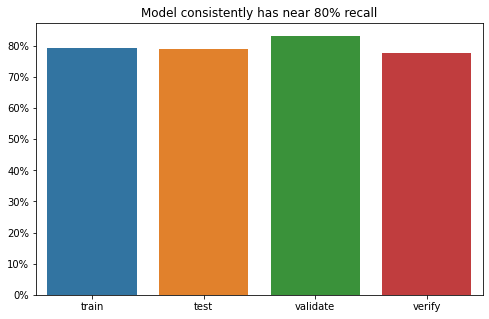

In [26]:
# Prepare some arrays to store our data in
xs = []
ys = []

# Loop through each sample set
for key, set in sets.items():
    # Make predictions
    pred = best_model.predict(set['x'])
    # Score predictions
    y = metrics.recall_score(set['y'], pred)
    # Store scores
    xs.append(key)
    ys.append(y)

# Plot the scores
plt.figure(figsize=(8,5))
sns.barplot(x=xs, y=ys).set(title='Model consistently has near 80% recall')
plt.gca().yaxis.set_major_formatter('{:.0%}'.format)
plt.show()

That's a good score, but the idea of recall and what that means for the company's return on investment can be a little hard to wrap our head around.  Since confusion matrixes can be, well, confusing.. I've found that plotting the results in a treemap makes it much easier to understand.

In [13]:
sample = sets['verify']['x']
actual = sets['verify']['y']
predictions = best_model.predict(sample)
cm = metrics.confusion_matrix(actual, predictions)
tn,fp,fn,tp = cm.ravel()
model.confusion_matrix_treemap(tn,fp,fn,tp)

By using geometry and the areas of each rectangle we can intuitively see how each outcome compares to the other.

In this example, only a small portion of customers who churned were missed, and while the size of false_positives are a little larger than the true_positives, the false_postives still make up a relatively small portion of the customers who did not churn.

This means that for all of the people that customer retention reache out to, half of them will be customers who would actually churn.

### But there's one more question worth asking:  Is this model really predicting better than chance?

#### $ Chi^2 $ test for model confidence  

To answer this question we can use the $ Chi^2 $ test once again by examining the confusion matrix and comparing it to the matrix we would expect if our predictions and the truth were independant of one another.

In [14]:
# Run the chi^2 test on the confusion matrix from earlier.
model.chi2_test(pd.DataFrame(cm))

Observed

[[558 218]
 [ 63 218]]
---
Expected

[[455 320]
 [165 115]]
---

chi^2 = 206.4371
degf = 1
p     = 0.0000
---

We reject the null hypothesis


Again we find a nearly 0% chance that we observed these results randomly.

## Conclusion

#### Analysis Summary:
This notebook has shown a strong tendancy for month-to-month customers and fiber optic customers to churn, as well as a recent spike in customers shown by their tenure.  This indicates the strong possibility of a recent promotion gone-awry.  

The steady increase in churn rate in the company's more tenured customers also indicates that this is more than a single promotion gone awry, and that there may be some issues with Fiber Optic Internet.

#### Reccomendations Summary:
This notebook has made the following recommendations to reduce churn
 - Use caution when introducing new promotions.
 - Monitoring internet service to ensure QoS.
 - Penalize month-to-month contracts with higher costs to steer more customers into longer term contracts while also recovering losses from churn.
 - Discout two-year contracts to further steer customers into longer term contracts.
 - Implement a machine learning model to monitor customers for risk of churn.



## Next Steps:
Further steps can be taken to improve the company's understanding of customer churn, such as:
 - Re-evaluating the dataset without the recent spike in customers.
 - Asking customers to take part in a survey when they leave to collect data on why they are leaving and their experience with the companay.
 - Collecting and storing data about which promotional offers (if any) a customer has used.

# Appendix

## Data preparation process

### Imputing missing values

In [15]:
# Load an uncleaned version of the data for demonstration purposes
df = wrangle.get_telco_data()


Data preparation was fairly straight forward.  There was very little missing data in the dataset.  The only exception occured with the `total_charges` column, with a total of 11 empty strings where we would expect a number.

In [16]:
df.total_charges.value_counts().nlargest(3) # 3 largest value counts in total charges

         11
20.2     11
19.75     9
Name: total_charges, dtype: int64

Instead of dropping those rows, I chose to impute them with a value of 0 because I noticed that those rows happened to all have a tenure of 0.  They are also the *only* rows with a tenure of 0.

In [17]:
# Get the customers with 0 tenure and show thier total charges
df[(df.tenure == 0)][['total_charges','tenure']]

,total_charges,tenure
945,,0
1731,,0
1906,,0
2025,,0
2176,,0
2250,,0
2855,,0
3052,,0
3118,,0
4054,,0


### Converting classes to ML friendly datatypes.

#### Trimming duplicated data in "binary" columns

For a majority of the columns, data was stored in a yes/no format.  Some columns included a value for if that column was not applicable to that customer.  
For example if we examine the values of `multiple_lines` we'll see the following:

|multiple_lines|count|
|---|---|
| No | 3390 |
| Yes | 2971 |
|No phone service| 682|

However, there is another column in the data set specifically describing if the customer has phone service.  It's called `phone_service`:

|phone_service|count|
|---|---|
| Yes | 6361 |
| No | 682 |

Because the count of `phone_service == 'no'` is the same as `multiple_lines == 'Mo phone service'` we can see that the data duplicated, and it is safe to destroy the extra copies of the data when we transform the multiple_lines column.  

The logic above is also true for columns relating to internet service because the data is duplicated from `internet_service_type == 'None'`.

In [18]:
# List all of the columns that can be transformed into Boolean datatypes
yes_no_columns = [ 'partner',
                'dependents',
                'phone_service',
                'multiple_lines',
                'online_security',
                'online_backup',
                'device_protection',
                'tech_support',
                'streaming_tv',
                'streaming_movies',
                'paperless_billing',
                'churn']
# For every column in the list, set the value to true if it is "Yes"
for column in yes_no_columns:
    df[column] = df[column] == "Yes"
# Make sure the transformations worked as expected.
df[yes_no_columns].head()

,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn
0,True,True,True,False,False,True,False,True,True,False,True,False
1,False,False,True,True,False,False,False,False,False,True,False,False
2,False,False,True,False,False,False,True,False,False,False,True,True
3,True,False,True,False,False,True,True,False,True,True,True,True
4,True,False,True,False,False,False,False,True,True,False,True,True
